# 🚦 Traffic Incident Analysis

This project explores traffic incident patterns in the City of Calgary using public incident data. We analyze spatial and temporal trends in Calgary using data mining techniques, spatial clustering, and temporal trend analysis with machine learning

## ✨ Project Goals
- Detect spatial hotspots using clustering (DBSCAN)
- Analyze incident frequency by hour, weekday, and season
- Predict incident counts with Random Forest Regression

## 📂 Structure
- `data/`: Raw and cleaned datasets
- `notebooks/`: JupyterLab analysis steps
- `output/`: Visualizations and results

## 🛠️ Tools
- Python, Pandas, Matplotlib, Seaborn, Scikit-learn, Folium
- JupyterLab for development
- GitHub for version control

## 📍 Data Source
[City of Calgary Open Data Portal - Traffic Incidents](https://data.calgary.ca/Transportation-Transit/Traffic-Incidents/35ra-9556)

---

# Step 1: Load and Preprocess Traffic Incident Data

In this step, we will:
- Import the traffic incidents dataset.
- Clean the data by removing missing or invalid values.
- Extract useful temporal features (hour, day of the week, month, season).
- Save the cleaned dataset for future use.

## Import Libraries

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load the Dataset

The dataset is update till March 31st 2025 and downloaded from the [City of Calgary Open Data Portal](https://data.calgary.ca/Transportation-Transit/Traffic-Incidents/35ra-9556), and stored in the `data/` folder.


In [58]:
df = pd.read_csv('../data/Traffic_Incidents_20250331.csv')

# Preview shape and column names
print("Shape:", df.shape)
df.columns


Shape: (53788, 10)


Index(['INCIDENT INFO', 'DESCRIPTION', 'START_DT', 'MODIFIED_DT', 'QUADRANT',
       'Longitude', 'Latitude', 'Count', 'id', 'Point'],
      dtype='object')

## Clean the Dataset

- Convert `START_DT` to datetime format
- Drop rows with missing or invalid coordinates.
- Filter out invalid lat/long points outside Calgary's range.

In [61]:
# Convert START_DT to datetime
df['START_DT'] = pd.to_datetime(df['START_DT'])

# Drop rows with missing latitude or longitude
df.dropna(subset=['Latitude', 'Longitude'], inplace=True)

# Filtering for valid Calgary coordinates
df = df[(df['Latitude'] > 50) & (df['Latitude'] < 52)]
df = df[(df['Longitude'] < -113) & (df['Longitude'] > -115)]

## Extract Temporal Features

We'll derive additional columns for:
- Hour of the day
- Day of the week
- Month of the year
- Season

In [64]:
# Extract time-based features
df['hour'] = df['START_DT'].dt.hour
df['day_of_week'] = df['START_DT'].dt.dayofweek  # 0 = Monday
df['month'] = df['START_DT'].dt.month
df['season'] = df['month'].map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
})

## Save the Cleaned Dataset

We'll export the preprocessed data to a new CSV file for use in analysis and modeling.

In [67]:
df.to_csv('../data/Traffic_Incidents_Cleaned.csv', index=False)
print("✅ Cleaned data saved successfully.")

✅ Cleaned data saved successfully.


## Preprocessed Data Summary

Let's inspect the cleaned dataset before proceeding with analysis.


In [74]:
# Reload the cleaned data just to be sure
df = pd.read_csv('../data/Traffic_Incidents_Cleaned.csv')

# Show first few rows
df.head()

# Check structure
df.info()

# Check for any remaining missing values
print("\nMissing values:\n", df.isnull().sum())

# Check unique values in key features
print("\nSeasons:", df['season'].unique())
print("Days of Week (0 = Monday):", df['day_of_week'].unique())
print("Unique months:", sorted(df['month'].unique()))
print("Hours:", sorted(df['hour'].unique()))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53788 entries, 0 to 53787
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   INCIDENT INFO  53788 non-null  object 
 1   DESCRIPTION    53786 non-null  object 
 2   START_DT       53788 non-null  object 
 3   MODIFIED_DT    39731 non-null  object 
 4   QUADRANT       39729 non-null  object 
 5   Longitude      53788 non-null  float64
 6   Latitude       53788 non-null  float64
 7   Count          53788 non-null  int64  
 8   id             53788 non-null  object 
 9   Point          53788 non-null  object 
 10  hour           53788 non-null  int64  
 11  day_of_week    53788 non-null  int64  
 12  month          53788 non-null  int64  
 13  season         53788 non-null  object 
dtypes: float64(2), int64(4), object(8)
memory usage: 5.7+ MB

Missing values:
 INCIDENT INFO        0
DESCRIPTION          2
START_DT             0
MODIFIED_DT      14057
QUADRANT       

# Step 2: Temporal Trends Analysis

In this step, we will explore temporal patterns in traffic incidents using:
- Hourly patterns (what time incidents peak)
- Weekly patterns (which days are busiest)
- Seasonal distribution (incidents by season)

The goal is to uncover meaningful trends that may improve model design and city traffic planning.


In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load preprocessed data
df = pd.read_csv('../data/Traffic_Incidents_Cleaned.csv')

# Basic check
df.head(2)

,INCIDENT INFO,DESCRIPTION,START_DT,MODIFIED_DT,QUADRANT,Longitude,Latitude,Count,id,Point,hour,day_of_week,month,season
0,Westbound 16 Avenue at Deerfoot Trail NE,Stalled vehicle. Partially blocking the right...,2022-06-21 07:31:40,2022/06/21 07:33:16 AM,NE,-114.026687,51.067485,1,2022-06-21T07:31:4051.067485129276236-114.0266...,POINT (-114.02668672232672 51.067485129276236),7,1,6,Summer
1,11 Avenue and 4 Street SW,Traffic incident. Blocking multiple lanes,2022-06-21 04:02:11,2022/06/21 04:12:38 AM,SW,-114.071481,51.042624,1,2022-06-21T04:02:1151.04262449261462-114.07148...,POINT (-114.07148057660925 51.04262449261462),4,1,6,Summer


## Traffic Incidents by Hour of the Day

C:\Users\Admin123\AppData\Local\Temp\ipykernel_44872\1417691601.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='hour', data=df, palette='viridis')


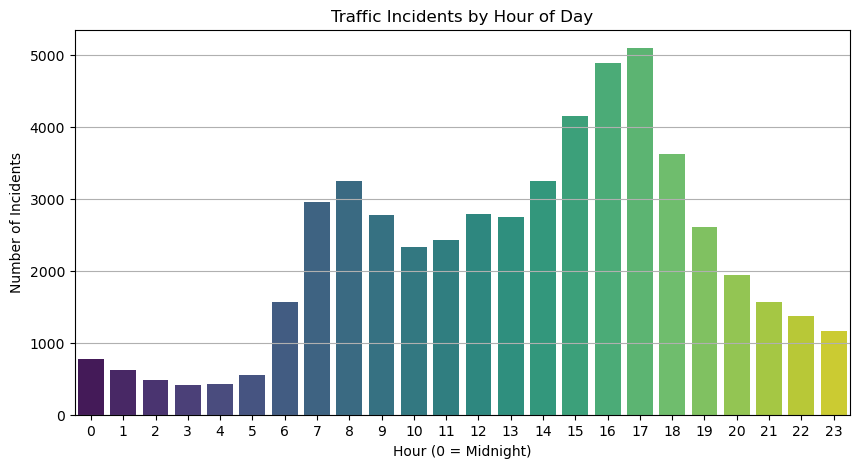

In [81]:
plt.figure(figsize=(10, 5))
sns.countplot(x='hour', data=df, palette='viridis')
plt.title("Traffic Incidents by Hour of Day")
plt.xlabel("Hour (0 = Midnight)")
plt.ylabel("Number of Incidents")
plt.xticks(range(0, 24))
plt.grid(axis='y')
plt.show()

## Traffic Incidents by Day of the Week

In Python, `0 = Monday` and `6 = Sunday`.

C:\Users\Admin123\AppData\Local\Temp\ipykernel_44872\1273545112.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='day_of_week', data=df, palette='magma')


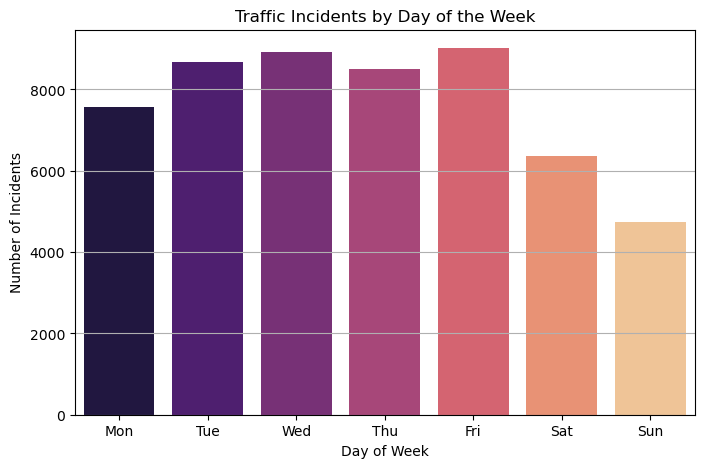

In [84]:
day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.figure(figsize=(8, 5))
sns.countplot(x='day_of_week', data=df, palette='magma')
plt.title("Traffic Incidents by Day of the Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Incidents")
plt.xticks(ticks=range(7), labels=day_labels)
plt.grid(axis='y')
plt.show()

## Traffic Incidents by Season

C:\Users\Admin123\AppData\Local\Temp\ipykernel_44872\811929288.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='season', data=df, order=['Winter', 'Spring', 'Summer', 'Fall'], palette='coolwarm')


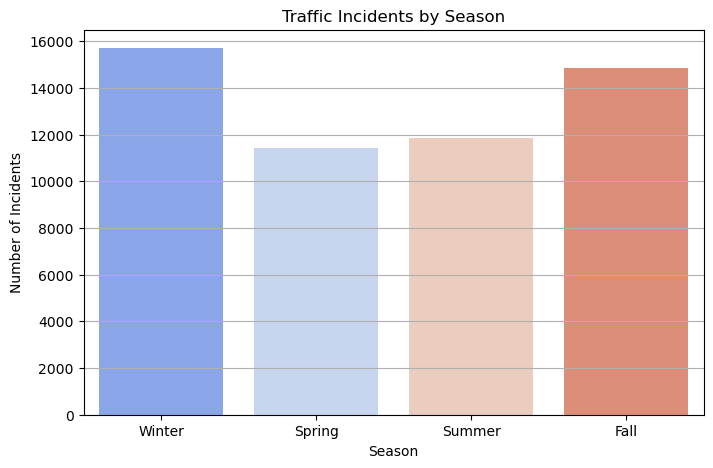

In [89]:
plt.figure(figsize=(8, 5))
sns.countplot(x='season', data=df, order=['Winter', 'Spring', 'Summer', 'Fall'], palette='coolwarm')
plt.title("Traffic Incidents by Season")
plt.xlabel("Season")
plt.ylabel("Number of Incidents")
plt.grid(axis='y')
plt.show()

## Traffic Incidents by Month

C:\Users\Admin123\AppData\Local\Temp\ipykernel_44872\2705017032.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='month', data=df, palette='crest')


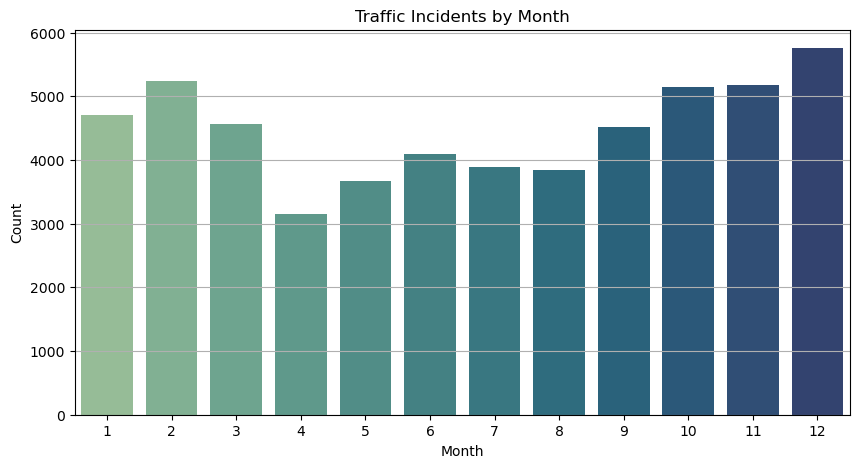

In [98]:
plt.figure(figsize=(10, 5))
sns.countplot(x='month', data=df, palette='crest')
plt.title("Traffic Incidents by Month")
plt.xlabel("Month")
plt.ylabel("Count")
plt.grid(axis='y')
plt.show()